In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

HSV_array = []

def dense_optical_flow(method, video_path, params=[], to_gray=False):
    # Read the video and first frame
    cap = cv.VideoCapture(video_path)
    ret, old_frame = cap.read()

    # crate HSV & make Value a constant
    hsv = np.zeros_like(old_frame)
    hsv[..., 1] = 255
    # Preprocessing for exact method
    if to_gray:
        old_frame = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)

    while True:
        # Read the next frame
        ret, new_frame = cap.read()
        frame_copy = new_frame
        if not ret:
            break

        # Preprocessing for exact method
        if to_gray:
            new_frame = cv.cvtColor(new_frame, cv.COLOR_BGR2GRAY)

        # Calculate Optical Flow
        flow = method(old_frame, new_frame, None, *params)

        # Encoding: convert the algorithm's output into Polar coordinates
        mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
        # Use Hue and Value to encode the Optical Flow
        hsv[..., 0] = ang * 180 / np.pi / 2
        hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)

        # Convert HSV image into BGR for demo
        bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
        # plt.imshow(frame_copy)
        # plt.show()
        HSV_array.append(bgr)
        k = cv.waitKey(25) & 0xFF
        if k == 27:
            break

        # Update the previous frame
        old_frame = new_frame

In [ ]:
dense_optical_flow(cv.optflow.calcOpticalFlowSparseToDense, "my_final_video.mp4")

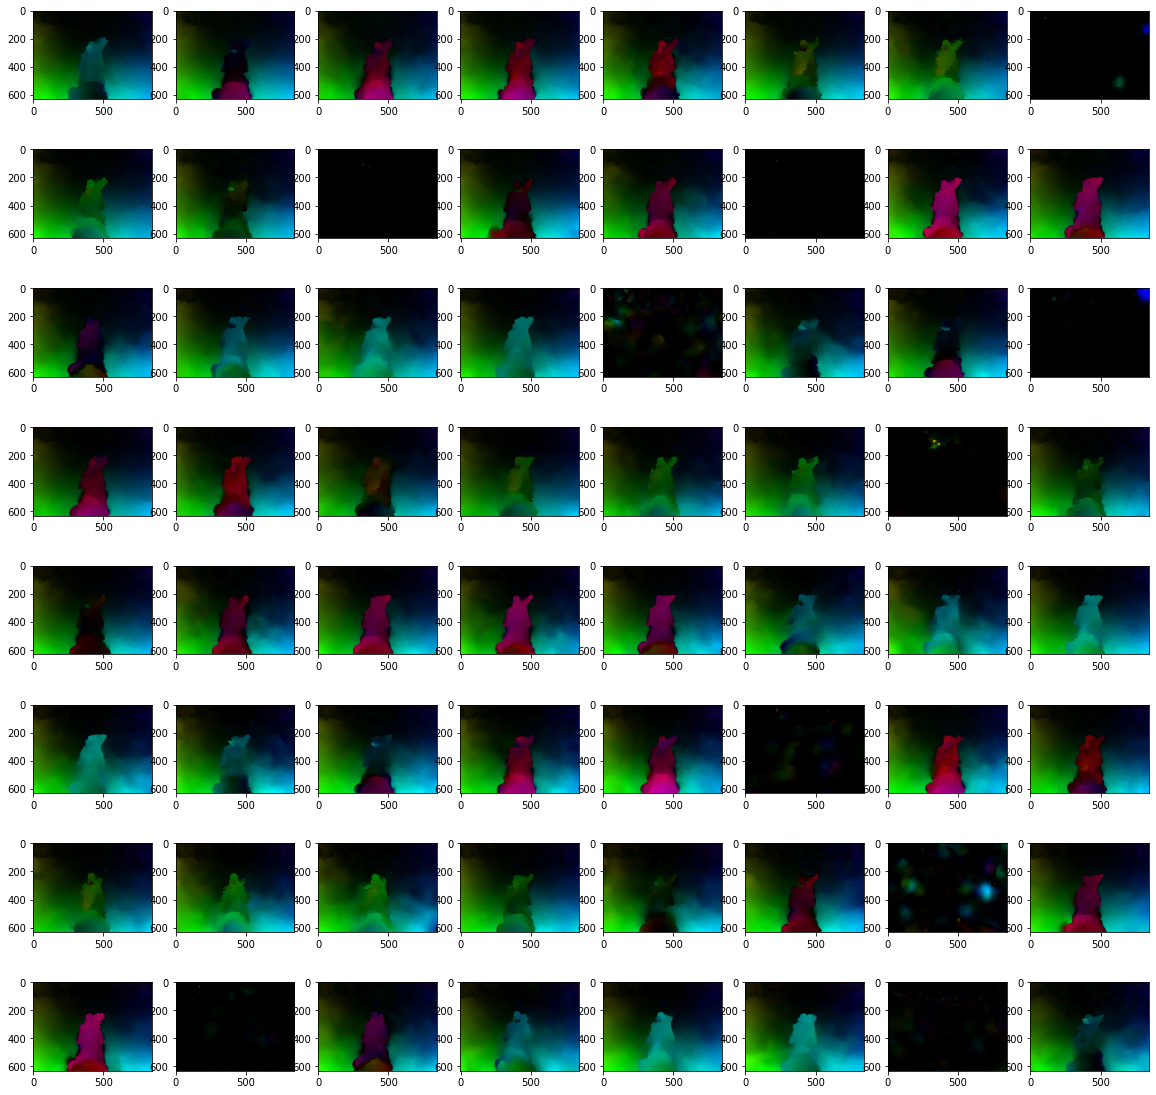

In [ ]:
nrows = 8
ncols = 8

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20, 20))

for i in range(nrows):
  for j in range(ncols):
    ax[i, j].imshow(HSV_array[i*ncols + j])
plt.show()

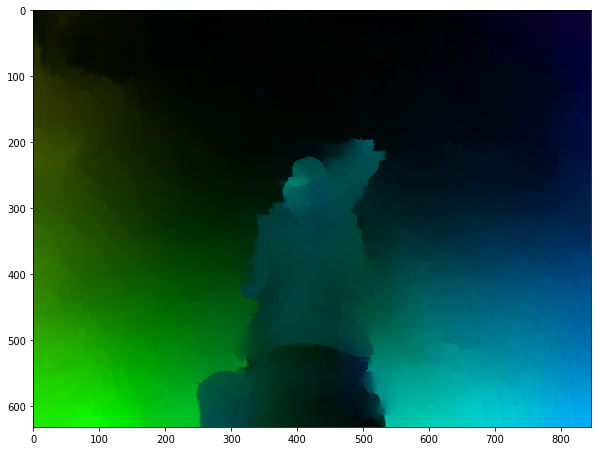

In [ ]:
plt.figure(figsize = (10, 10))
plt.imshow(HSV_array[0])
plt.show()

### Sparse Optical Flow

In [ ]:
o_f_array = []

def lucas_kanade_method(video_path):
    # Read the video 
    cap = cv.VideoCapture(video_path)

    # Parameters for ShiTomasi corner detection
    feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

    # Parameters for Lucas Kanade optical flow
    lk_params = dict(
        winSize=(15, 15),
        maxLevel=2,
        criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03),
    )

    # Create random colors
    color = np.random.randint(0, 255, (100, 3))

    # Take first frame and find corners in it
    ret, old_frame = cap.read()
    old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
    p0 = cv.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)

    while True:
      # Read new frame
      ret, frame = cap.read()
      if not ret:
          break
      frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

      # Calculate Optical Flow
      p1, st, err = cv.calcOpticalFlowPyrLK(
          old_gray, frame_gray, p0, None, **lk_params
      )
      # Select good points
      good_new = p1[st == 1]
      good_old = p0[st == 1]

      # Draw the tracks
      for i, (new, old) in enumerate(zip(good_new, good_old)):
          a, b = new.ravel()
          c, d = old.ravel()
          mask = cv.line(mask, (a, b), (c, d), color[i].tolist(), 2)
          frame = cv.circle(frame, (a, b), 5, color[i].tolist(), -1)

      # Display the demo
      img = cv.add(frame, mask)
      o_f_array.append(img)
      k = cv.waitKey(25) & 0xFF
      if k == 27:
          break

      # Update the previous frame and previous points
      old_gray = frame_gray.copy()
      p0 = good_new.reshape(-1, 1, 2)

In [ ]:
lucas_kanade_method("my_final_video.mp4")

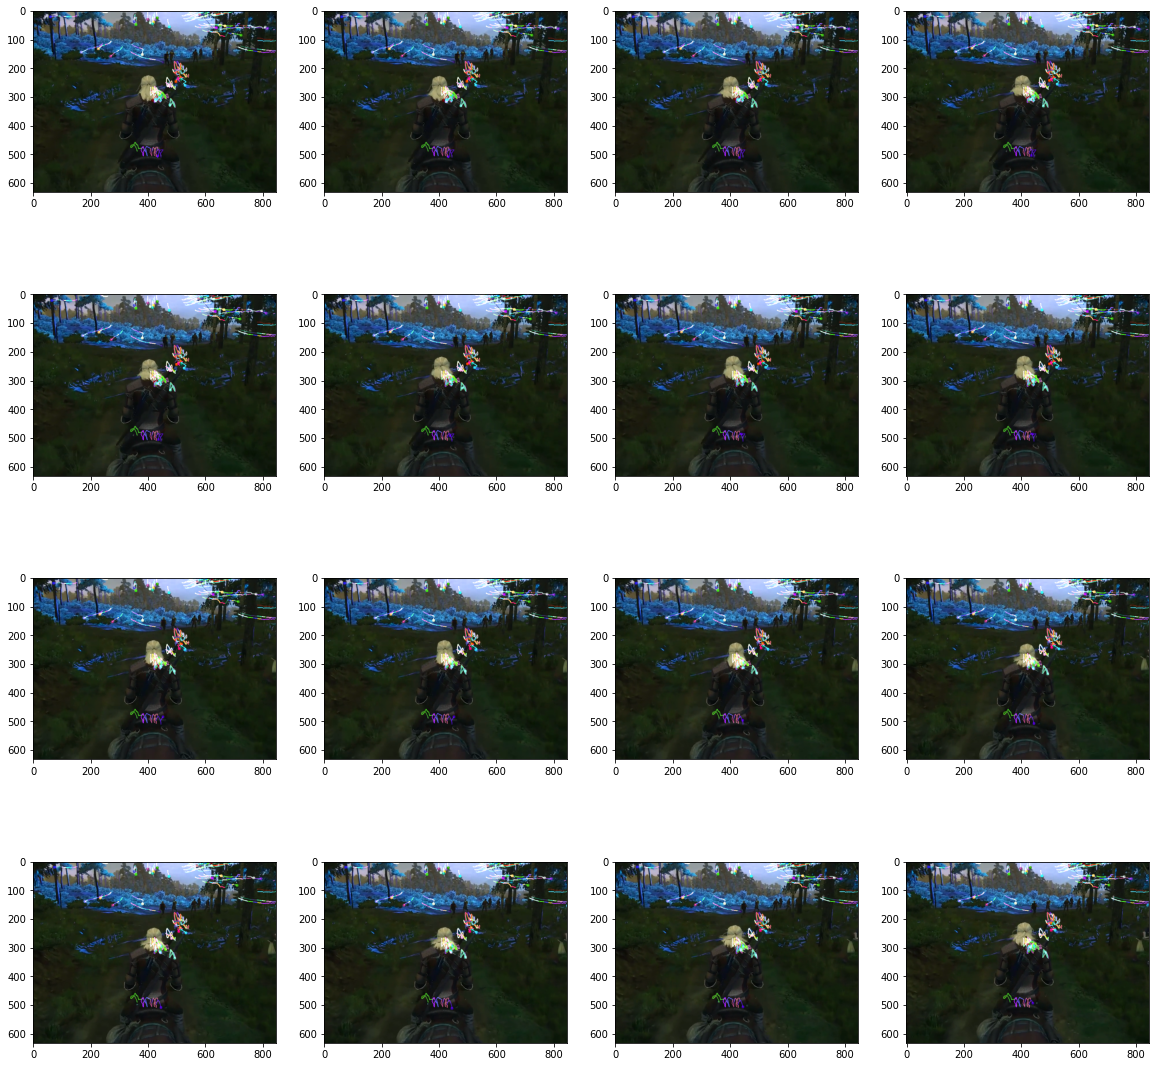

In [ ]:
nrows = 4
ncols = 4

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20, 20))

for i in range(nrows):
  for j in range(ncols):
    ax[i, j].imshow(o_f_array[::-1][i*ncols + j])

plt.show()

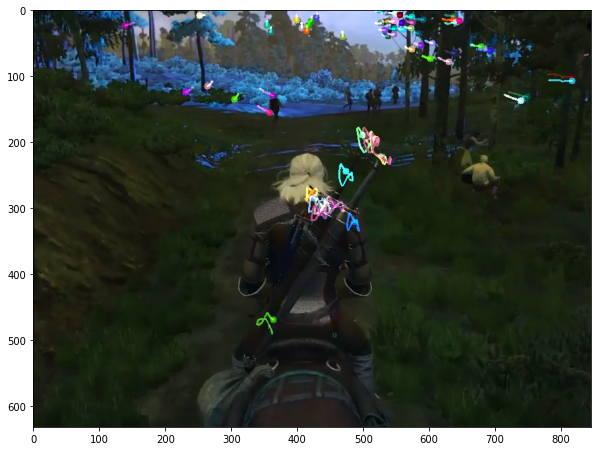

In [ ]:
plt.figure(figsize = (10, 10))
plt.imshow(o_f_array[18])
plt.show()